In [13]:
import pandas as pd
import numpy as np
import datetime
from datetime import date
import random

from functions import *

from sklearn.linear_model import LinearRegression

import seaborn as sns
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

# athlete level model

In [14]:
#create model for calculating athlete level
data = {'speed': [4.291573333333333, 5.109015873015872, 2.2351944444444443, 2.682233333333333], 
        'distance': [26.2, 3.1, 26.2, 3.1],'level': [10, 10, 1, 1]}
df_pace_lvl = pd.DataFrame(data)

#calculate slope and intercept -linear
X = df_pace_lvl[['speed', 'distance']]
y = df_pace_lvl['level']
level = LinearRegression().fit(X, y)
print('score: ', level.score(X, y))
print('coefficients: ', level.coef_)
print('intercept: ', level.intercept_)

score:  0.9932200383740991
coefficients:  [3.98780213 0.10914506]
intercept:  -10.373329770791926


# distance factor model

In [15]:
#modeling distance factor from athl_level (bound to 1-10)
data = {'level': [10, 1], 
        'dist_factor': [1, 0.5]}
df_distance_lvl = pd.DataFrame(data)
dist_model = np.poly1d(np.polyfit(df_distance_lvl['level'], df_distance_lvl['dist_factor'], 1))

# longest long run model (marathon only)

In [16]:
#modeling distance factor from athl_level (bound to 1-10)
data = {'level': [10, 1], 
        'max_lr': [23, 18]}
df_max_lr = pd.DataFrame(data)
lr_model = np.poly1d(np.polyfit(df_max_lr['level'], df_max_lr['max_lr'], 1))

In [17]:
lr_model(7.410528903816044)

21.561404946564476

# workout files

In [18]:
df_5k = pd.read_csv('workouts/5k.csv')
df_10k = pd.read_csv('workouts/10k.csv')
df_half = pd.read_csv('workouts/half_mar.csv')
df_full = pd.read_csv('workouts/full_mar.csv')

# main function for base calendar 

In [28]:
#function to date race date, number of weeks to train, and generate 
def get_calendar(race_year, race_month, race_day, weeks, pace_min, pace_sec, race_dist):
    
    #calcluate meters per second (speed) from goal pace
    speed = mins_to_meters(m=pace_min, s=pace_sec)
    
    race_date = date(race_year, race_month, race_day+1)
    
    cal = weeks*7
    
    date_list = [race_date - datetime.timedelta(days=x) for x in range(1,(cal+1))]
    
    date_list.reverse()
    
    days = []

    for x in date_list:
        days.append(x.weekday())
        
    data = {'date': date_list, 'day_code': days}
    
    df_training_cal = pd.DataFrame(data)
    
    #create validation table for weekday codes/desc to join to training calendar
    weekdays = {'day_code': range(0,7), 'day_desc': ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']}
    df_weekdays = pd.DataFrame(weekdays)
    df_weekdays
    
    df_training_cal = pd.merge(df_training_cal, df_weekdays, how='left', on='day_code')
    
    #find first monday and crop calendar down to start on first monday
    first_mon = df_training_cal[df_training_cal.day_code == 0].index[0]
    df_training_cal = df_training_cal.iloc[first_mon:]
    
    #create column for week count
    week = []
    count = 0
    for index, row in df_training_cal.iterrows():
        if row.day_code == 0:
            count += 1
            week.append(count)
        else:
            week.append(count)
    df_training_cal['week']=week
    
    #create column for training phase
    #2 week taper for blocks under 14 weeks, 3 week taper for blocks >= 14 weeks
    block = 0
    if weeks < 14:
        block += (df_training_cal.week.max() - 2)
    if weeks >= 14:
        block += (df_training_cal.week.max() - 3)
    base = np.ceil(block*0.4)
    peak = np.floor(block*0.6)

    phase= []

    for index, row in df_training_cal.iterrows():
        if row.week <= base:
            phase.append('base')
        elif row.week-base <= peak:
            phase.append('peak')
        else:
            phase.append('taper')
    df_training_cal['phase']=phase
    
    #calculate level and assign to level raw (used for pace calc)
    #if level raw is outside range(1,10), bound to nearest level and assign to dist_level (used for max distance calc)
    user_X = pd.DataFrame({'speed': [speed], 'distance': [race_dist]})
    level_raw = level.predict(user_X)[0]
    dist_level = []
    
    if level_raw < 1:
        dist_level.append(1)
    elif level_raw > 10:
        dist_level.append(10)
    else:
        dist_level.append(level_raw)
        
    #calculate paces (to be used for workouts)
    b1 = level.coef_[0]
    b2 = level.coef_[1]
    b0 = level.intercept_

    five_k = ((level_raw - b0) - (3.1*b2)) / b1
    ten_k = ((level_raw - b0) - (10.2*b2)) / b1
    hmp = ((level_raw - b0) - (13.1*b2)) / b1
    mp = ((level_raw - b0) - (26.2*b2)) / b1
    z2 = mp*0.825
    
    #weekly mileage peak
    mileage_max = 0
    if race_dist == 3.1:
        mileage_max += 45
    elif race_dist == 6.2:
        mileage_max += 50
    elif race_dist == 13.1:
        mileage_max += 60
    elif race_dist == 26.2:
        mileage_max += 75
        
    dist_factor = dist_model(dist_level[0]) 
    
    user_max = mileage_max*dist_factor
    #user_max = mileage_max-(level_final[0]*3)
    
    #weekly mileage
    base = len(df_training_cal.loc[df_training_cal.phase=='base'].week.unique())
    peak = len(df_training_cal.loc[df_training_cal.phase=='peak'].week.unique())
    taper = len(df_training_cal.loc[df_training_cal.phase=='taper'].week.unique())
    
    week_1 = round(user_max/3, 1)
    build = user_max-week_1
    weekly_miles = []
    
    week_num = []
    
    for index, row in df_training_cal.iterrows():
        if row.week not in week_num:
            week_num.append(row.week)
            
    weekly_miles = [week_1]
    miles = 0
    
    for i in range(1,base):
        miles += build/(base-1)
        weekly_miles.append(round(week_1+miles, 1))
    
    for i in range(1, peak+1):
        weekly_miles.append(round(user_max, 1))
    
    if taper == 2:
        weekly_miles.append(user_max*0.7)
        weekly_miles.append(user_max*0.4)
        
    if taper == 3:
        weekly_miles.append(round(user_max*0.85, 1))
        weekly_miles.append(round(user_max*0.65, 1))
        weekly_miles.append(round(user_max*0.3, 1))
    
    data = {'week': week_num, 'mileage': weekly_miles}
    df_mileage = pd.DataFrame(data)
    
    #add weekly mileage into df_training_cal
    weekly_mileage = []
    for index, row in df_training_cal.iterrows():
        weekly_mileage.append(df_mileage.loc[df_mileage.week == row.week].mileage.values[0])
    
    df_training_cal["weekly_mileage"] = weekly_mileage
    
    #add down week for training blocks >= 14 weeks
    if weeks >= 14:
        down_phase = []
        down_mileage = []
        
        for index, row in df_training_cal.iterrows():
            if row.week == (base + (peak-2)):
                down_phase.append('down')
                down_mileage.append(round(user_max*0.5, 1))
            else:
                down_phase.append(row.phase)
                down_mileage.append(row.weekly_mileage)
                
        df_training_cal['phase']=down_phase
        df_training_cal['weekly_mileage']=down_mileage
        
    ###LONG RUNS###
    
    #establish max long run distance
    max_lr = 0
    if (race_dist == 3.1) and (user_max/3 <= 10):
        max_lr += round(user_max/3, 1)
    elif (race_dist == 3.1) and (user_max/3 > 10):
        max_lr += 10
    elif (race_dist == 6.2) and (user_max/3 <= 12):
        max_lr += round(user_max/3, 1)
    elif (race_dist == 6.2) and (user_max/3 > 12):
        max_lr += 12
    elif (race_dist == 13.1) and (user_max/3 <= 18):
        max_lr += round(user_max/3, 1)
    elif (race_dist == 13.1) and (user_max/3 > 18):
        max_lr += 18
    #for full-marathon, use linear model
    elif (race_dist == 26.2):
        max_lr += lr_model(dist_level)[0]
    
    #max_lr = max_lr[0]
    lr_85pct = round(max_lr*0.85, 1)
    lr_90pct = round(max_lr*0.9, 1)
    lr_95pct = round(max_lr*0.95,1)
    base_lr = []
    lr1 = round(df_training_cal.loc[df_training_cal.week==1].weekly_mileage.unique()[0]/3, 1) #1/3 of first week total mileage,1)
    peak_lr = []
    down_lr = []
    postdown_lr = []
    taper_lr = []

    #base long runs
    base_step = (max_lr - lr1) / (base-1)
    base_lr_holder = lr1
    base_lr.append(lr1)

    for i in range(1,base):
        base_lr_holder+=base_step
        base_lr.append(round(base_lr_holder, 1))
    
    #if down week exists
    if weeks >= 14:
        #peak to down week long runs
        peak_lr.append(lr_85pct)
        down_week = df_training_cal.loc[df_training_cal.phase == 'down'].week.unique()[0]
        peak_weeks = len(df_training_cal.loc[(df_training_cal.phase == 'peak') & (df_training_cal.week < down_week)].week.unique())
        lr_diff = max_lr - lr_85pct
        step = lr_diff/(peak_weeks-1) 

        lr_holder = lr_85pct
        for i in range(1,peak_weeks):
            lr_holder+=step
            peak_lr.append(round(lr_holder, 1))
    
        #down week long run
        for index, row in df_training_cal.iterrows():
            if (row.day_code == 5) and (row.phase == 'down') and (row.weekly_mileage/3 < max_lr):
                down_lr.append(round(row.weekly_mileage/3, 1))

        #post down week peak long runs
        postdown_peak = len(df_training_cal.loc[(df_training_cal.phase == 'peak') & (df_training_cal.week > down_week)].week.unique())
        for i in range(1,postdown_peak+1):
            postdown_lr.append(lr_95pct)
    
    #if no down week
    else:
        peak_lr.append(lr_85pct)
        peak_weeks = len(df_training_cal.loc[(df_training_cal.day_code ==5) & (df_training_cal.phase == 'peak')])
        lr_diff = max_lr - lr_85pct
        step = lr_diff/(peak_weeks-1) 

        lr_holder = lr_85pct
        for i in range(1,peak_weeks):
            lr_holder+=step
            peak_lr.append(round(lr_holder, 1))
            
            
    #taper long runs
    for index, row in df_training_cal.iterrows():
        if (row.day_code == 5) and (row.phase == 'taper') and (row.weekly_mileage/3 < max_lr):
            taper_lr.append(round(row.weekly_mileage/3, 1))
        elif (row.day_code == 5) and (row.phase == 'taper') and (row.weekly_mileage/3 >= max_lr):
            taper_lr.append(lr_85pct)
            
    long_runs = base_lr + peak_lr + down_lr + postdown_lr + taper_lr
    
    #daily distance, run types, and run descriptions
    #runs per week
    runs_per_wk = []
    for index, row in df_training_cal.iterrows():    
        #if weekly mileage under 20, assign rest days to mon, fri, sun
        if (row.weekly_mileage < 21.99):
            runs_per_wk.append(4)
        #if weekly mileage btw 20 and 40, assign rest days to mon, fri
        elif (row.weekly_mileage >= 22) & (row.weekly_mileage < 39.99):
            runs_per_wk.append(5)
        #if weekly mileage btw 40 and 55, assign rest day to mon
        elif (row.weekly_mileage >= 40) & (row.weekly_mileage < 54.99):
            runs_per_wk.append(6)
        #plug in LR distance on saturdays
        else:
            runs_per_wk.append(7)
        
    df_training_cal['runs_per_week'] = runs_per_wk
    
    #dist, run type, run_desc
    distance = []
    run_type = []
    run_desc = []
    run_name = []

    for index, row in df_training_cal.iterrows():    
        #if 4 runs per week, assign rest days to mon, fri, sun
        if (row.runs_per_week == 4) & (row.day_code in [0, 4, 6]):
            distance.append(0)
            run_type.append('rest')
            run_desc.append('This is a rest day. Prioritize relaxation and recovery.')
            run_name.append('Rest Day')
    
        #if 5 runs per week, assign rest days to mon, fri
        elif (row.runs_per_week == 5) & (row.day_code in [0, 4]):
            distance.append(0)
            run_type.append('rest')
            run_desc.append('This is a rest day. Prioritize relaxation and recovery.')
            run_name.append('Rest Day')
        #if 6 runs per week, assign rest day to mon
        elif (row.runs_per_week == 6) & (row.day_code == 0):
            distance.append(0)
            run_type.append('rest')
            run_desc.append('This is a rest day. Prioritize relaxation and recovery.')
            run_name.append('Rest Day')
        
        #plug in LR distance on saturdays
        elif (row.day_code == 5) & (row.week != df_training_cal.week.max()):
            lr_index = row.week - 1
            distance.append(round(long_runs[lr_index], 1))
            run_type.append('long_run')
            run_desc.append('The goal of this run is to build endurance, not speed. Keep the effort easy and focus on completing the distance')
            run_name.append('Long Run')
        #fill the rest with easy days
        else:
            lr_index = row.week - 1
            filler_dist = (row.weekly_mileage - long_runs[lr_index])/(row.runs_per_week - 1)
            distance.append(round(filler_dist, 1))     
            run_type.append('easy')
            run_desc.append('This run should be easy enough that you could carry on a conversation throughout the run.')
            run_name.append('Easy Day')

        
    df_training_cal['distance'] = distance
    df_training_cal['run_type'] = run_type
    df_training_cal['run_desc'] = run_desc
    df_training_cal['run_name'] = run_name
    
    ##WORKOUT ASSIGNMENT##
    distance = df_training_cal.distance.tolist()
    run_type = df_training_cal.run_type.tolist()
    run_desc = df_training_cal.run_desc.tolist()
    run_name = df_training_cal.run_name.tolist()

    #if marathon
    if race_dist == 26.2:
    
        easy = df_full.loc[(df_full.phase == 'base') & (dist_level[0] > df_full.dist_level_min) & (dist_level[0] < df_full.dist_level_max) & (df_full.workout_type=='workout')].index.tolist()
        hard = df_full.loc[(df_full.phase == 'speed') & (dist_level[0] > df_full.dist_level_min) & (dist_level[0] < df_full.dist_level_max) & (df_full.workout_type=='workout')].index.tolist()
        long = df_full.loc[(df_full.phase == 'speed') & (dist_level[0] > df_full.dist_level_min) & (dist_level[0] < df_full.dist_level_max) & (df_full.workout_type=='long_run')].index.tolist()
        taper = df_full.loc[(df_full.phase == 'base') & (df_full.dist_level_max<=5)].index.tolist()
    
        random.shuffle(easy)
        random.shuffle(hard)
        random.shuffle(long)
        random.shuffle(taper)
    
    
        easy_seq = easy*4
        hard_seq = hard*4
        long_seq = long*4
        taper_seq = taper #only need one taper workout
        print(hard_seq)

        easy_counter=0
        hard_counter=0
        long_counter=0
    
        #if level >= 5: base phase has weekly w/o + easy LR
        #peak phase has weekly w/o and hard LR
        if level_raw >= 5:
            for index, row in df_training_cal.iterrows():           
                if (row.phase in ['base', 'taper', 'down']) & (row.day_code == 2) & (row.week != df_training_cal.week.max()):
                    #update wednesday run_type, desc, and dist with easy_seq
                    distance[index]=df_full.iloc[easy_seq[easy_counter]]['distance']
                    run_type[index]='workout'
                    run_desc[index]=df_full.iloc[easy_seq[easy_counter]]['desc']
                    run_name[index]=df_full.iloc[easy_seq[easy_counter]]['name']
                    easy_counter+=1
                elif (row.phase == 'peak') & (row.day_code == 2):
                    #update wednesday run_type, desc, and dist with hard_seq
                    distance[index]=df_full.iloc[hard_seq[hard_counter]]['distance']
                    run_type[index]='workout'
                    run_desc[index]=df_full.iloc[hard_seq[hard_counter]]['desc']
                    run_name[index]=df_full.iloc[hard_seq[hard_counter]]['name']
                    hard_counter+=1
                #long run workouts from peak - 2 weeks out
                elif (row.phase in ['peak', 'taper']) & (row.day_code == 5) & (row.week <= df_training_cal.week.max()-2):
                    #update saturday run_type, desc, and dist with hard_seq
                    run_type[index]='long_workout'
                    run_desc[index]=df_full.iloc[long_seq[long_counter]]['desc']
                    run_name[index]=df_full.iloc[long_seq[long_counter]]['name']
                    long_counter+=1
                #deal with final week
                #add strides to easy days, make w/o lowest level, add race to race day
                elif row.week == df_training_cal.week.max():
                    if (row.run_type == 'easy') & (row.day_code != 2):
                        run_desc[index]='The majority of this run should be at your usual easy pace, but do 3-5 reps of 30-60 second efforts at your goal race pace in the final mile of the run.\
                        This will allow you to maintain your top-end fitness as you taper toward race day.'
                        run_name[index]='Easy + Strides'
                    elif row.day_code == 2:
                        distance[index]=df_full.iloc[taper_seq[0]]['distance']
                        run_type[index]='workout'
                        run_desc[index]=df_full.iloc[taper_seq[0]]['desc']
                        run_name[index]=df_full.iloc[taper_seq[0]]['name']
                #add race day to calendar
                if row.date == df_training_cal.date.max():
                    run_type[index]='race'
                    run_desc[index]='Race day has arrived! Be patient, stick to your plan, and trust in your training. Good luck!'
                    run_name[index]='Race Day'
                    distance[index]=race_dist
                else:
                    continue
                
        #if level < 5: base phase all easy
        #peak phase has weekly w/o and easy LRs
        if level_raw < 5:
            for index, row in df_training_cal.iterrows():           
                if (row.phase == 'peak') & (row.day_code == 2):
                    #update wednesday run_type, desc, and dist with hard_seq
                    distance[index]=df_full.iloc[hard_seq[hard_counter]]['distance']
                    run_type[index]='workout'
                    run_desc[index]=df_full.iloc[hard_seq[hard_counter]]['desc']
                    run_name[index]=df_full.iloc[hard_seq[easy_counter]]['name']
                    hard_counter+=1
                else:
                    continue
            
        #update training cal with new run types, desc, and names
        df_training_cal['run_type'] = run_type
        df_training_cal['run_desc'] = run_desc
        df_training_cal['run_name'] = run_name
        df_training_cal['distance'] = distance
        
        #re-calc filler dist
        df1 = df_training_cal.loc[df_training_cal.run_type != 'easy'].groupby(['week']).agg({'weekly_mileage': 'first', 'distance':'sum'}).reset_index()
        df2 = df_training_cal.loc[df_training_cal.run_type == 'easy'].groupby(['week'])['week'].count().reset_index(name='easy_days')
        df1 = pd.merge(df1, df2, on='week', how='left')
        df1['easy_mileage']=(df1.weekly_mileage - df1.distance)/df1.easy_days
        #df1.to_csv('df_filler.csv', index=False)
        for index, row in df_training_cal.iterrows():
            if (row.run_type == 'easy') & (row.week != df_training_cal.week.max()):
                distance[index]=round(df1.loc[df1.week==row.week]['easy_mileage'].values[0], 1)    
            else:
                continue
        df_training_cal['distance'] = distance
    
        ##PACE ASSIGNMENT##
        #paces as strings
        z2_str=pace_to_str(z2)
        mp_str=pace_to_str(mp)
        hmp_str=pace_to_str(hmp)
        tenk_str=pace_to_str(ten_k)
        fivek_str=pace_to_str(five_k)
        
        pace = []
        for index, row in df_training_cal.iterrows():
            #all easy runs and long runs at z2 pace
            if row.run_type in ['easy', 'long_run']:
                pace.append(z2_str)
            #workouts in base phase all at MP
            elif (row.phase=='base') & (row.run_type=='workout'):
                pace.append(mp_str)
            #workouts in speed, down, and taper phase at 10k-hmp
            elif (row.phase in ['peak', 'down', 'taper']) & (row.run_type=='workout'):
                pace.append(tenk_str + ' - ' + hmp_str)
            #lr workouts
            elif row.run_type=='long_workout':
                pace.append(mp_str)
            elif row.run_type=='race':
                pace.append(pace_to_str(speed))
            else:
                #pace='-' for rest days
                pace.append('-')
                 
        df_training_cal['pace'] = pace
    
    return df_training_cal, level_raw, dist_level, user_max, df_mileage, \
            speed, five_k, ten_k, hmp, mp, z2, long_runs, max_lr, peak_lr, lr_85pct, race_dist

In [33]:
result = get_calendar(race_year=2023, race_month=11, race_day=19, weeks=16, pace_min=7, pace_sec=10, race_dist=26.2)

print('raw level: ', result[1])
print('dist level: ', result[2])
print('z2: ', pace_to_str(result[10]))
print('mp: ', pace_to_str(result[9]))
print('hmp: ', pace_to_str(result[8]))
print('10k: ', pace_to_str(result[7]))
print('5k: ', pace_to_str(result[6]))
result[0][['date', 'day_desc', 'week', 'phase', 'distance', 'run_type', 'run_name', 'pace', 'run_desc']].to_csv('nick_philly.csv', index=False)

[14, 6, 11, 8, 14, 6, 11, 8, 14, 6, 11, 8, 14, 6, 11, 8]
raw level:  7.410528903816044
dist level:  [7.410528903816044]
z2:  8'41''
mp:  7'10''
hmp:  6'32''
10k:  6'25''
5k:  6'08''


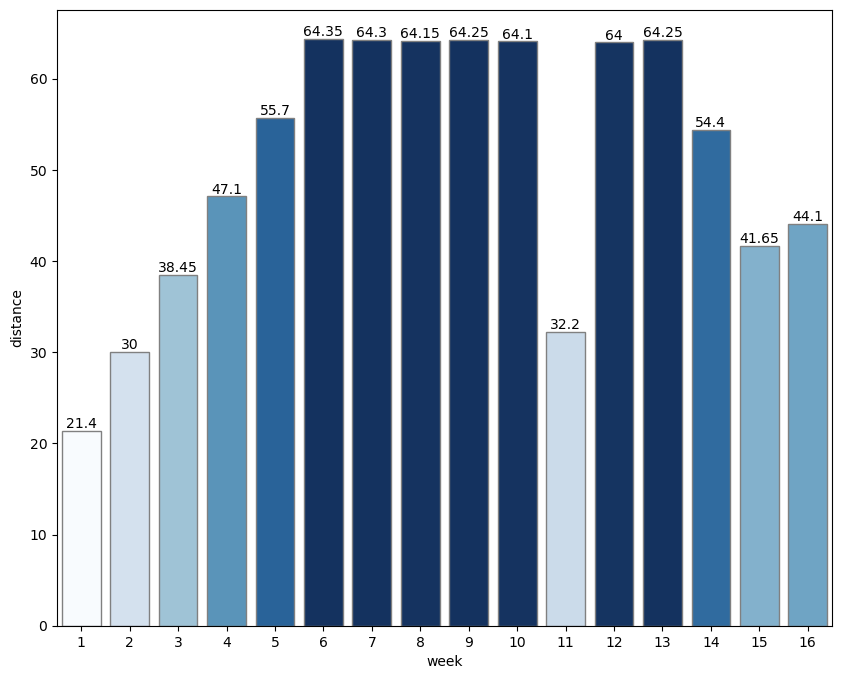

In [34]:
df_vol = result[0].groupby(['week'])['distance'].sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(data=df_vol, x='week', y='distance', edgecolor='grey', 
            palette=plt.cm.ScalarMappable(cmap='Blues').to_rgba(df_vol['distance']), ax=ax)

ax.bar_label(ax.containers[0]);

plt.savefig('philly_mileage2.jpg')

In [11]:
print('all_lrs: ', result[10])
print('max_lr: ', result[11]) 
print('peak_lrs: ', result[12])
print('85pct_lr: ', result[13])

all_lrs:  3.052196551724138
max_lr:  [7.1, 10.7, 14.3, 17.9, 21.5, 18.2, 19.8, 21.5, 10.6, 20.4, 20.4, 18.0, 13.8, 6.3]
peak_lrs:  21.466484377649625
85pct_lr:  [18.2, 19.8, 21.5]


In [321]:
result[0][['week', 'phase', 'weekly_mileage']].drop_duplicates()

,week,phase,weekly_mileage
0,1,base,20.3
7,2,base,30.4
14,3,base,40.5
21,4,base,50.7
28,5,base,60.8
35,6,peak,60.8
42,7,peak,60.8
49,8,peak,60.8
56,9,down,30.4
63,10,peak,60.8


In [317]:
#check weekly mileage totals
result[0].groupby(['week']).agg({'weekly_mileage': 'first', 'distance': 'sum'})

,weekly_mileage,distance
week,,
1,20.3,20.20
2,30.4,30.55
3,40.5,40.50
4,50.7,50.50
5,60.8,60.85
6,60.8,60.90
7,60.8,60.75
8,60.8,60.85
9,30.4,30.40


In [318]:
result[0].loc[result[0].week == result[0].week.max()]

,date,day_code,day_desc,week,phase,weekly_mileage,runs_per_week,distance,run_type,run_desc,run_name,pace
91,2023-11-13,0,Mon,14,taper,18.2,4,0.0,rest,This is a rest day. Prioritize relaxation and ...,Rest Day,-
92,2023-11-14,1,Tues,14,taper,18.2,4,4.0,easy,The majority of this run should be at your usu...,Easy + Strides,9'12''
93,2023-11-15,2,Wed,14,taper,18.2,4,4.0,workout,1.5 mile warm up followed by 5 reps of approx...,5 x 1 minute hill sprints,6'45'' - 6'53''
94,2023-11-16,3,Thurs,14,taper,18.2,4,4.0,easy,The majority of this run should be at your usu...,Easy + Strides,9'12''
95,2023-11-17,4,Fri,14,taper,18.2,4,0.0,rest,This is a rest day. Prioritize relaxation and ...,Rest Day,-
96,2023-11-18,5,Sat,14,taper,18.2,4,4.0,easy,The majority of this run should be at your usu...,Easy + Strides,9'12''
97,2023-11-19,6,Sun,14,taper,18.2,4,26.2,race,"Race day has arrived! Be patient, stick to you...",Race Day,7'35''


In [37]:
df_nick = pd.read_csv('nick_philly.csv')
df_nick.groupby(['week'])['distance'].sum().reset_index()

,week,distance
0,1,21.40
1,2,30.00
2,3,38.45
3,4,47.10
4,5,55.70
5,6,64.35
6,7,64.30
7,8,64.15
8,9,64.25
9,10,64.10
